<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Natural Language Processing For Everyone</h1>
        <h1>Topic Modeling</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import string
from collections import Counter
from pprint import pprint
import gzip

import matplotlib
import matplotlib.pyplot as plt 

import numpy as np
from numpy.linalg import svd
from numpy import diag

import watermark

%matplotlib inline
%load_ext watermark

List out the versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 842cbaa9fb86ca89575a80bfaea9a8abcdb598ac

matplotlib: 3.3.2
numpy     : 1.20.1
watermark : 2.1.0
json      : 2.0.9



Set the default style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Preprocessing

Load a standard list of stopwords from a file

In [4]:
stopwords = set([word.lower().strip() for word in open("data/nltk_stopwords.txt", "rt").readlines()])

In [5]:
list(stopwords)[:10]

['their',
 'i',
 'wouldn',
 'is',
 'had',
 'ourselves',
 'into',
 'hadn',
 'mightn',
 'doing']

Define a function to extract the words from our input file. Here we have to be (slightly) more careful than in the previous lesson since we want to keep #tags and @mentions and remove stopwords.

In [6]:
def extract_words(text, stopwords):
    temp = text.split() # Split the text on whitespace
    text_words = []

    punctuation = set(string.punctuation)
    
    #Keep #tags and @mentions
    punctuation.remove("#")
    punctuation.remove("@")
    
    for word in temp:
        # Remove any punctuation characters present in the beginning of the word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]

        # Remove any punctuation characters present in the end of the word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]

        # Simple rule to eliminate (most) URLs "http://www.google.com"
        if len(word) > 0 and "/" not in word:
            # If it's not a stopword
            if word.lower() not in stopwords:
                # Append this word into our list of words.
                text_words.append(word.lower())
        
    return text_words

Process the data from the file. File was obtained from crowdflower (https://www.crowdflower.com/data-for-everyone/) and contains a list of tweets about Apple from 2014 and some information about their sentiment. For our purposes, we only care about the text of each tweet that is located in the last column of the csv file.

We treat each tweet as an individual document, and limit ourselves to only the first 200 tweets.

In [7]:
tweets = []
line_count = 0

for line in open("data/Apple-Twitter-Sentiment-DFE.csv", "rt"):
    fields = line.strip().split(',')
    
    line_count += 1
    
    # Skip the first line of the file which contains the header
    if line_count == 1:
        continue
    
    text = ",".join(fields[11:])
    
    if len(text) == 0:
        continue
    
    words = extract_words(text, stopwords)
    
    if len(words) > 0:
        tweets.append(words)
        
    if len(tweets) == 200:
        break

In [8]:
tweets[:5]

[['cat', 'chews', '@apple', 'cords', '#applesnob'],
 ['nobody', 'expects', 'spanish', 'inquisition', '#aapl'],
 ['#aapl:5', 'rocket', 'stocks', 'buy', 'december', 'gains', 'apple'],
 ['top', '3', '@apple', '#tablets', 'damn', 'right'],
 ['apple', 'inc', 'flash', 'crash', 'need', 'know', '#aapl']]

Define the function to calculate the Inverse Document Frequency for each word and the TFIDF matrix. These functions were introduced in the previous lesson.

In [9]:
def inv_doc_freq(corpus_words):
    number_docs = len(corpus_words)
    
    document_count = {}

    for document in corpus_words:
        word_set = set(document)

        for word in word_set:
            document_count[word] = document_count.get(word, 0) + 1
    
    IDF = {}
    
    for word in document_count:
        IDF[word] = np.log(number_docs/document_count[word])
        
    
    return IDF

def tf_idf(corpus_words):
    IDF = inv_doc_freq(corpus_words)
    
    TFIDF = []
    
    for document in corpus_words:
        TFIDF.append(Counter(document))
    
    for document in TFIDF:
        for word in document:
            document[word] = document[word]*IDF[word]
            
    return TFIDF

Get the TFIDF matrix for our corpus of tweets. We should note that while we call it a matrix, this is effectively a list of dictionaries, which we can consider to be a sparse representation of a matrix.

In [10]:
TFIDF = tf_idf(tweets)

In [11]:
TFIDF[:5]

[Counter({'cat': 5.298317366548036,
          'chews': 5.298317366548036,
          '@apple': 0.2169130015635736,
          'cords': 5.298317366548036,
          '#applesnob': 5.298317366548036}),
 Counter({'nobody': 5.298317366548036,
          'expects': 5.298317366548036,
          'spanish': 5.298317366548036,
          'inquisition': 5.298317366548036,
          '#aapl': 1.9310215365615626}),
 Counter({'#aapl:5': 5.298317366548036,
          'rocket': 5.298317366548036,
          'stocks': 5.298317366548036,
          'buy': 3.506557897319982,
          'december': 4.605170185988092,
          'gains': 5.298317366548036,
          'apple': 2.5902671654458267}),
 Counter({'top': 5.298317366548036,
          '3': 4.605170185988092,
          '@apple': 0.2169130015635736,
          '#tablets': 5.298317366548036,
          'damn': 4.605170185988092,
          'right': 3.912023005428146}),
 Counter({'apple': 2.5902671654458267,
          'inc': 3.6888794541139363,
          'flash': 4.

For convenience, extract the word_dict and word_list from the TFIDF matrix.

In [12]:
def build_vocabulary(TFIDF):
    words = set()
    
    for document in TFIDF:
        words |= set(document.keys())
    
    word_list = list(words)
    word_dict = dict(zip(word_list, range(len(word_list))))
    
    return word_dict, word_list

In [13]:
word_dict, word_list = build_vocabulary(TFIDF)

In [14]:
vocabulary_size = len(word_dict)
print("We have", vocabulary_size, "words in our vocabulary")

We have 927 words in our vocabulary


In [15]:
word_list[:10]

['past',
 'fixed',
 'battery',
 '@aydlettgwyn13',
 'restore',
 'turkey',
 'aapl',
 '2015',
 'startup',
 'truly']

Now use the TFIDF matrix and our vocabulary to generate the Term Document matrix. This is just a matter of rearranging the values in our (sparse) TFIDF matrix into the full TD matrix.

In [16]:
def term_document_matrix(TFIDF, word_list, word_dict):
    vocabulary_size = len(word_dict)
    number_documents = len(TFIDF)
    
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]
        
        for word in document.keys():
            pos = word_dict[word]
            
            TDM[pos, doc] = document[word]
            
    return TDM

In [17]:
TDM = term_document_matrix(TFIDF, word_list, word_dict)
print("Our dataset has:\n%u unique words\n%u documents"%(TDM.shape))

Our dataset has:
927 unique words
200 documents


In [18]:
TDM.shape

(927, 200)

## Explicit Semantic Analysis

In ESA we use the TD matrix of our corpus as a knowledge base that we can use to look up related documents. To demonstrate how this works, let's create a new document:

In [19]:
new_tweet = ['#macbook', 'mini', 'rocket']

This is not an actual sentence since, for clarity, we are not including stopwords.

In the TD formulation, the values in the word (row) vector representa how much each document is "activated" by that specific word. Naturally, documents in which the word does not appear have weight zero. We can use these word vectors to find a vector representation of our new document where each value is our related it is to every other document in our knowledge base. You can think of this as the set of results one might obtain after a query in a search engine!

The **find_related** simply calcuates the vector corresponding to the new "document" and returns a list of the corresponding weights sorted in decreasing order:

In [20]:
def find_related_docs(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
        
    # Now the entries of new_vector tell us which documents are activated by this one.
    # Let's extract the list of documents sorted by activation
    doc_list = sorted(zip(range(TDM.shape[1]), new_vector), 
                      key=lambda x:x[1], reverse=True)
    
    return doc_list

In [21]:
related = find_related_docs(new_tweet, TDM)

Let's take a look a the top 5 results:

In [22]:
for tweet, score in related[:5]:
    print(score, tweet, " ".join(tweets[tweet]))

6.607650686531799 166 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
6.607650686531799 167 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox
6.607650686531799 190 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
6.607650686531799 191 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox
5.298317366548036 2 #aapl:5 rocket stocks buy december gains apple


With such small documents, the results are easy to interpret. The first two result are due to mentions of **macbook** and **mini**, the third due to the presence of the word **rocket** but the remaining two results don't include any words in common with our original tweet, just words that appear in similar contexts.

In [23]:
def similarity(vec1, vec2):
    sim = np.dot(vec1, vec2)
    norm1 = np.sqrt(np.dot(vec1, vec1))
    norm2 = np.sqrt(np.dot(vec2, vec2))
    
    return sim/(norm1*norm2)

In [24]:
def find_similar_words(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
    
    sim = [similarity(new_vector, TDM[i, :]) for i in range(TDM.shape[0])]
    
    sim_words = sorted(zip(range(TDM.shape[0]), sim), 
                       key=lambda x:x[1], reverse=True)
    
    return sim_words

In [25]:
similar = find_similar_words(new_tweet, TDM)

In [26]:
new_tweet

['#macbook', 'mini', 'rocket']

In [27]:
for word, score in similar[:10]:
    print(word_list[word], score)

#macbook 0.842346298979266
#startup 0.8273747381258668
@youtube 0.8273747381258668
#hipster 0.8273747381258668
mini 0.8227410508913036
#ipadmini 0.7963450852368475
#macbookpro 0.7800563838816592
ipad 0.7617102018231607
via 0.7055875474518816
#ipad 0.6502130393344844


This approach also returns words that are not included in the document but that are used in a similar context, such as #hipster. One might use this extra words (above some finetuned threshold of similarity) to expand our query and retrieve furhter related documents.

## Latent Semantic Analysis

LSA analysis, sometimes refered to as Latent Semantic Indexing, relies on the well known Singular Value Decomposition. Singular Values (and Singular Vectors) can be thought of as being a generalization of the more common eigenvalues (and eigenvectors) for the case of non-square matrices. 

The first step in any LSA analysis is to apply SVD to the Term-Document matrix:

In [28]:
u, sigma, vt = svd(TDM)

The resulting matrices have the expected shapes, except the singular value matrix, **sigma** that is simply a vector. This is an optimization of the numpy function meant to save memory.

In [29]:
m, n = TDM.shape
print(u.shape, sigma.shape, vt.shape)

(927, 927) (200,) (200, 200)


In [30]:
print(m, n)

927 200


We can now reduce the internal dimention of these matrices to, say, 10. 

In [31]:
k = 10

# Convert the vector of singular values into a diagonal matrix
sigma_k = sigma[:k]
Sk = diag(sigma_k)

# Drop the extraneous dimensions in the other two matrices.
uk = u[:,:k]
vtk = vt[:k, :]

In this way, we preserve the most significant (higher sigma values) latent dimensions of the dataset while discarding the rest. The idea is simple, SVD projects the original dataset into an internal space which is a linear combination of the original one. Each dimension in this space can be thought of as an underlying topic in the data. By preserving only the most dominant topics in effect we are simplifying the data and, potentially, removing noise. 

In [32]:
print(uk.shape, Sk.shape, vtk.shape)

(927, 10) (10, 10) (10, 200)


There are no easy ways to determine the number of topics to choose, but a good rule of thumb is to identify kinks in the values of sigma

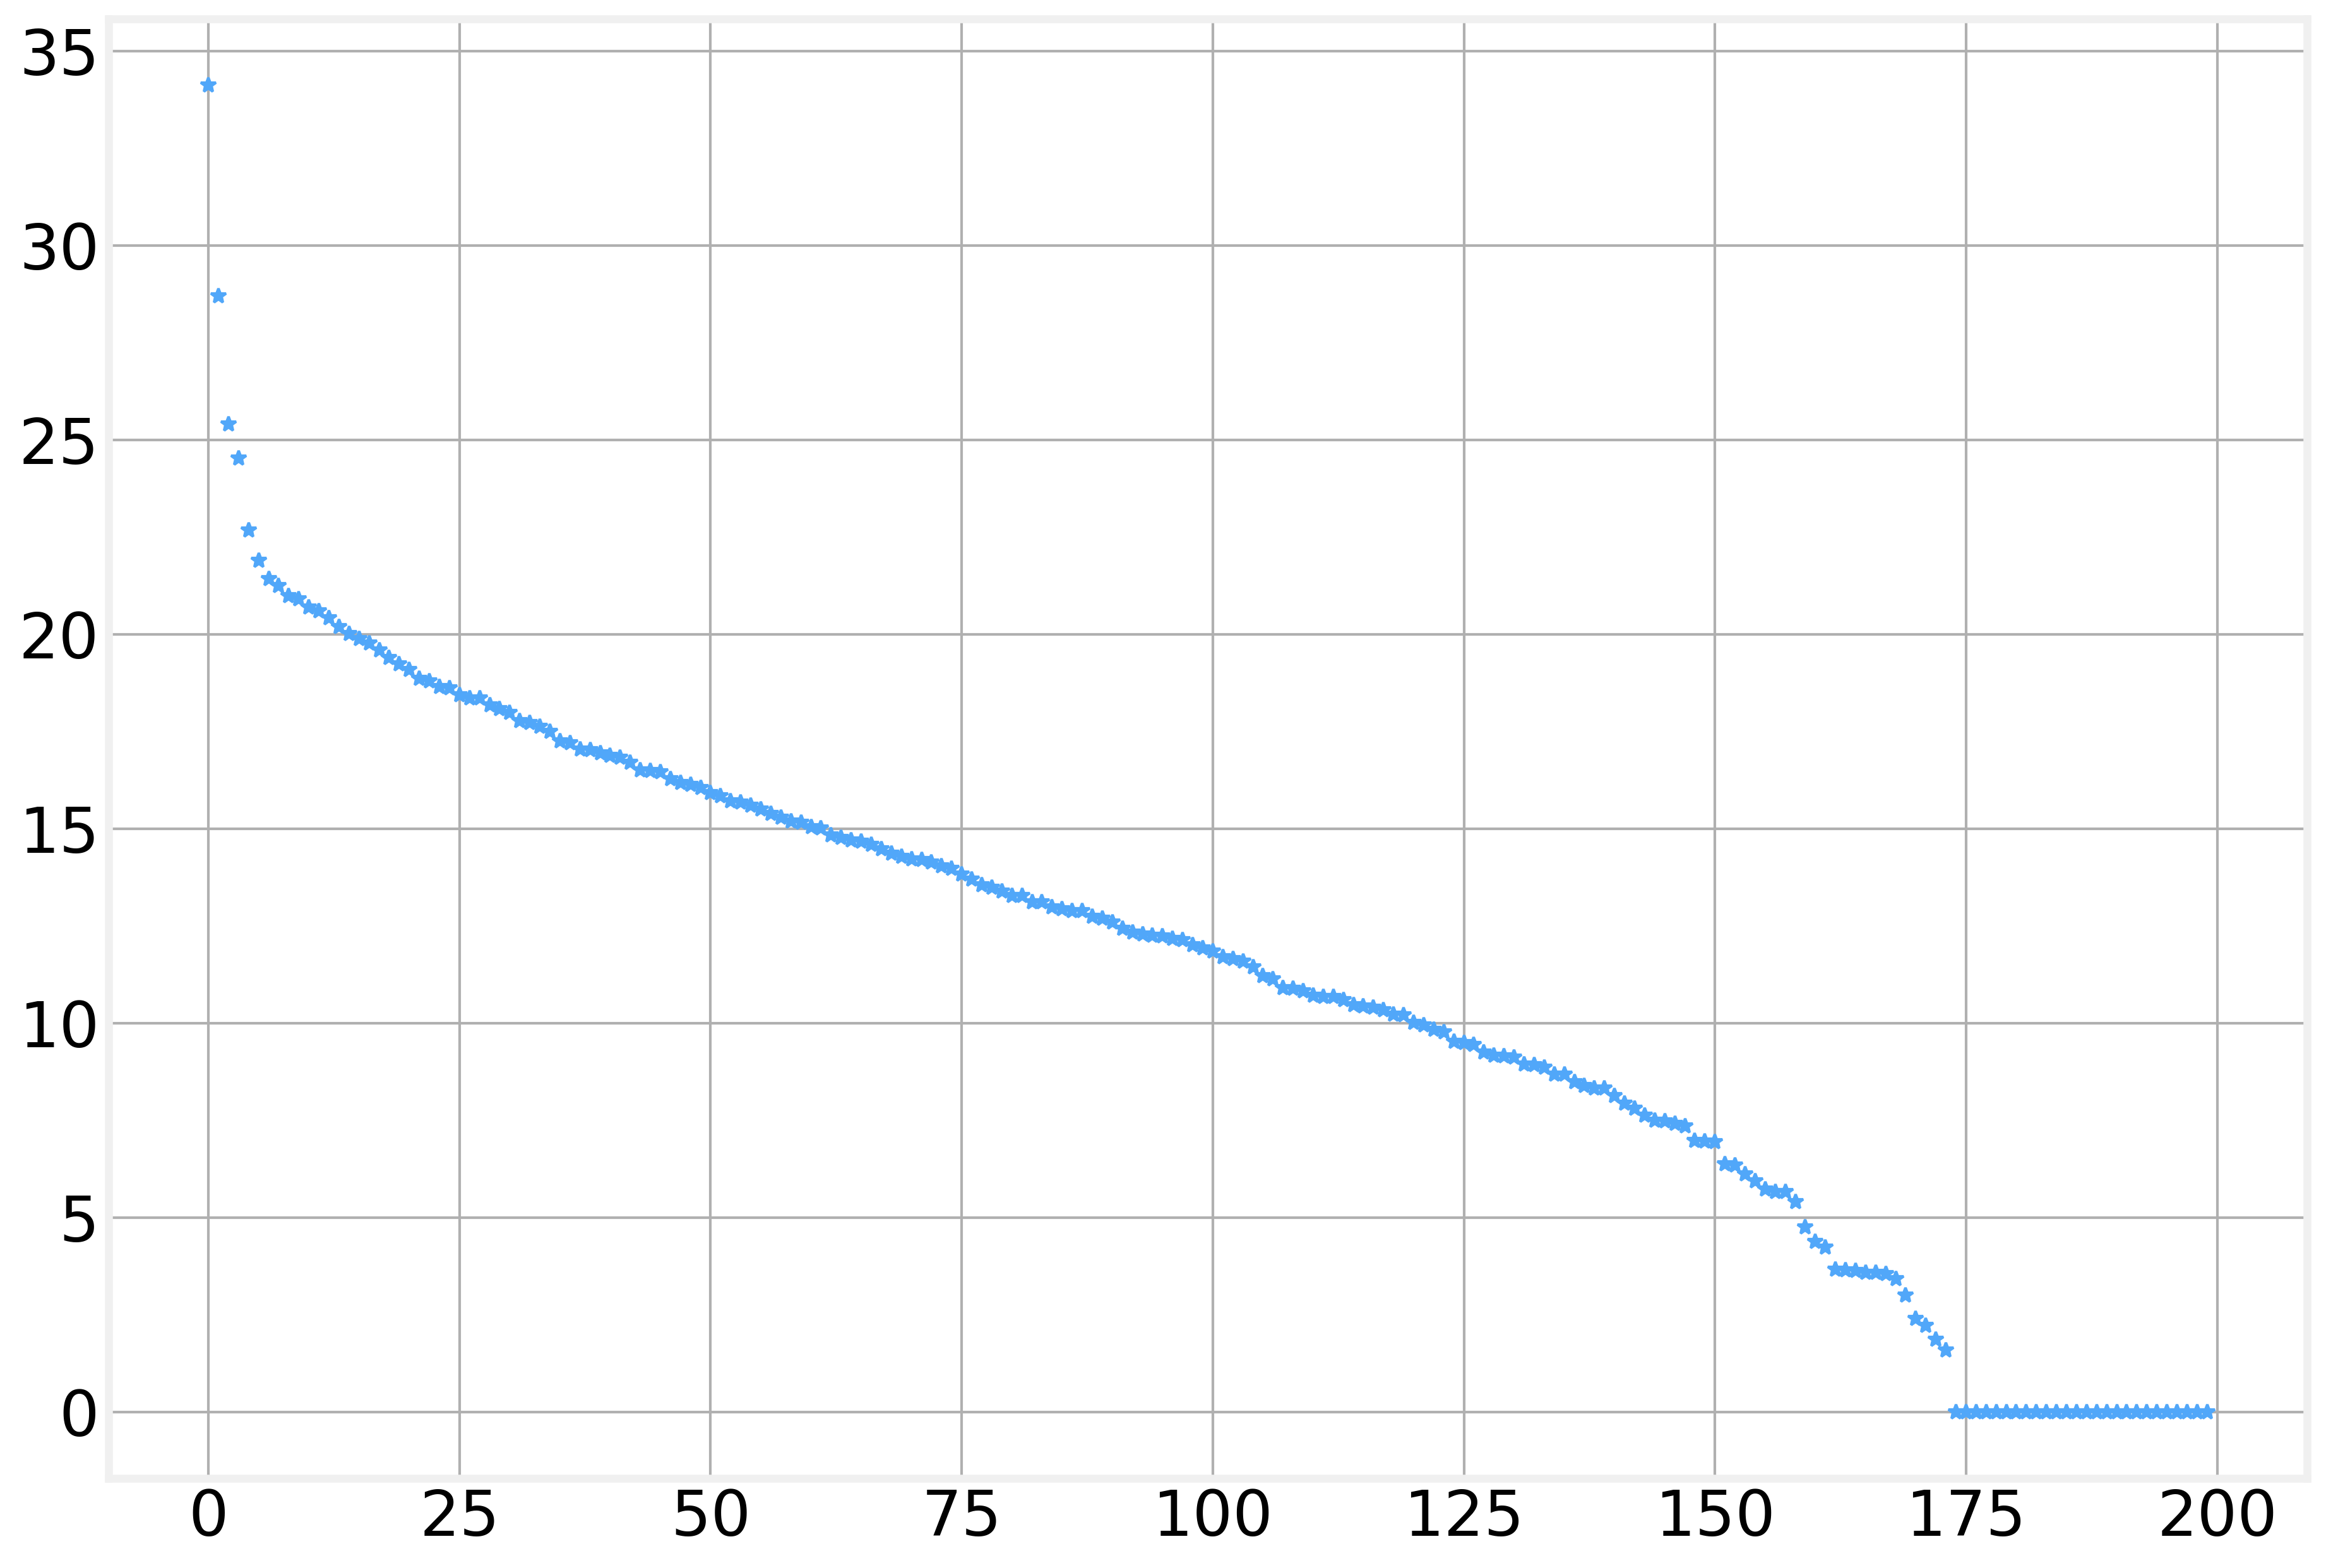

In [33]:
plt.plot(range(200), sigma, '*')

We can also explore the way in which the topics are defined by considering the words for which they have stronger weights:

In [34]:
# Sort the list of words by the weight they have in a specific topic
def top_words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

For example, for topic 3, we have strong mentions of AIDS day and the Produc (RED) iPhone launch:

In [35]:
topic_words = top_words(uk[:,2], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

@youtube 0.01749645375681092
#hipster 0.01749645375681092
#startup 0.01749645375681091
#macbookpro 0.017132628189497574
#macbook 0.012528116903347517
#ipadmini 0.011422691880213403
mini 0.011170775074262949
#unboxing 0.010859207427756458
unboxing 0.010859207427756458
iphones 0.010425900889972436


On the other hand, if we were trying to map a specific sentence or document into the most relevant topic we would simply have to project it into the singular space. First we define the vector in the "regular" word space:

In [36]:
document = ['ipad', 'mini', 'price']

doc_vector = np.zeros(vocabulary_size)
for word in document:
    doc_vector[word_dict[word]] += 1

and now we project it into the singular space:

In [37]:
doc_singular = 1/sigma_k*np.dot(uk.T, doc_vector)
pprint(doc_singular)

array([ 1.62243400e-04,  1.44900491e-02, -1.09973213e-03,  4.30257980e-05,
        9.69106965e-04, -4.54646796e-03,  7.58613138e-04, -2.40772326e-03,
        3.82599561e-03, -1.95924079e-03])


From where we see that the most relevant topic is topic number 1:

In [38]:
topic = np.argmax(doc_singular)

print(topic)

topic_words = top_words(uk[:,topic], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

1
#macbook 0.30723559382138993
@youtube 0.30540145699726673
#hipster 0.30540145699726673
#startup 0.3054014569972665
#macbookpro 0.29809606289080237
via 0.2918795721098772
mini 0.20949666233803643
ipad 0.20381766001212523
#ipadmini 0.19891025664321701
startup 0.19327488007614904


Which indeed seems relevant.

## Non-Negative Matrix Factorization

The idea behind applying NMF to a Term-Document Matrix is similar to the goals behind using SVD to perform Latent Semantic Analysis. NMF is a general matrix factorization algorithm and, as such, the factor matrices it finds can also be thought of as internal or latent dimensions. 

Similarly to the case of SVD, we can perform a partial reconstruction of the original matrix by reducing the internal dimensions. Naturally, as the number of latent dimensions increases, the reconstruction error decreases since we are removing less and less information:

In [39]:
def NMF(V, k):
    n, m = V.shape

    W = np.random.random((n, k))
    H = np.random.random((k, m))

    error = 1
    err = 1

    while err > 1e-3:
        old_error = error

        hn = np.dot(W.T, V)
        hd = np.dot(W.T, np.dot(W, H))

        H = H*np.divide(hn, hd)

        wn = np.dot(V, H.T)
        wd = np.dot(W, np.dot(H, H.T))

        W = W*np.divide(wn, wd)

        error = np.sum(np.power(V-np.dot(W, H), 2.0))
        err = np.abs(old_error-error)

    return W, H, error

Let's see how the error changes with the number of components.

In [40]:
error = []

for comps in range(2, 25+1):
    W, H, err = NMF(TDM, comps)
    print(comps, err)
    error.append(err)

2 32018.603459602975
3 31373.953197805804
4 30774.253535613003
5 30268.692424579047
6 29816.698570980716
7 29367.403900046946
8 28944.16041848501
9 28503.03902206096
10 28103.67467143985
11 27636.79478285254
12 27267.88238520606
13 26786.088694686474
14 26502.51980850024
15 25975.15889895014
16 25685.577639186708
17 25312.89917390399
18 24904.67793529409
19 24516.89759187186
20 24183.654993559485
21 23843.883502707256
22 23455.560119189042
23 23081.739130922553
24 22766.209108463943
25 22394.109264653955


Any nan values found above are due to numerical instabilities. In practice you should use a well tested numerical library such as sklearn.

Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

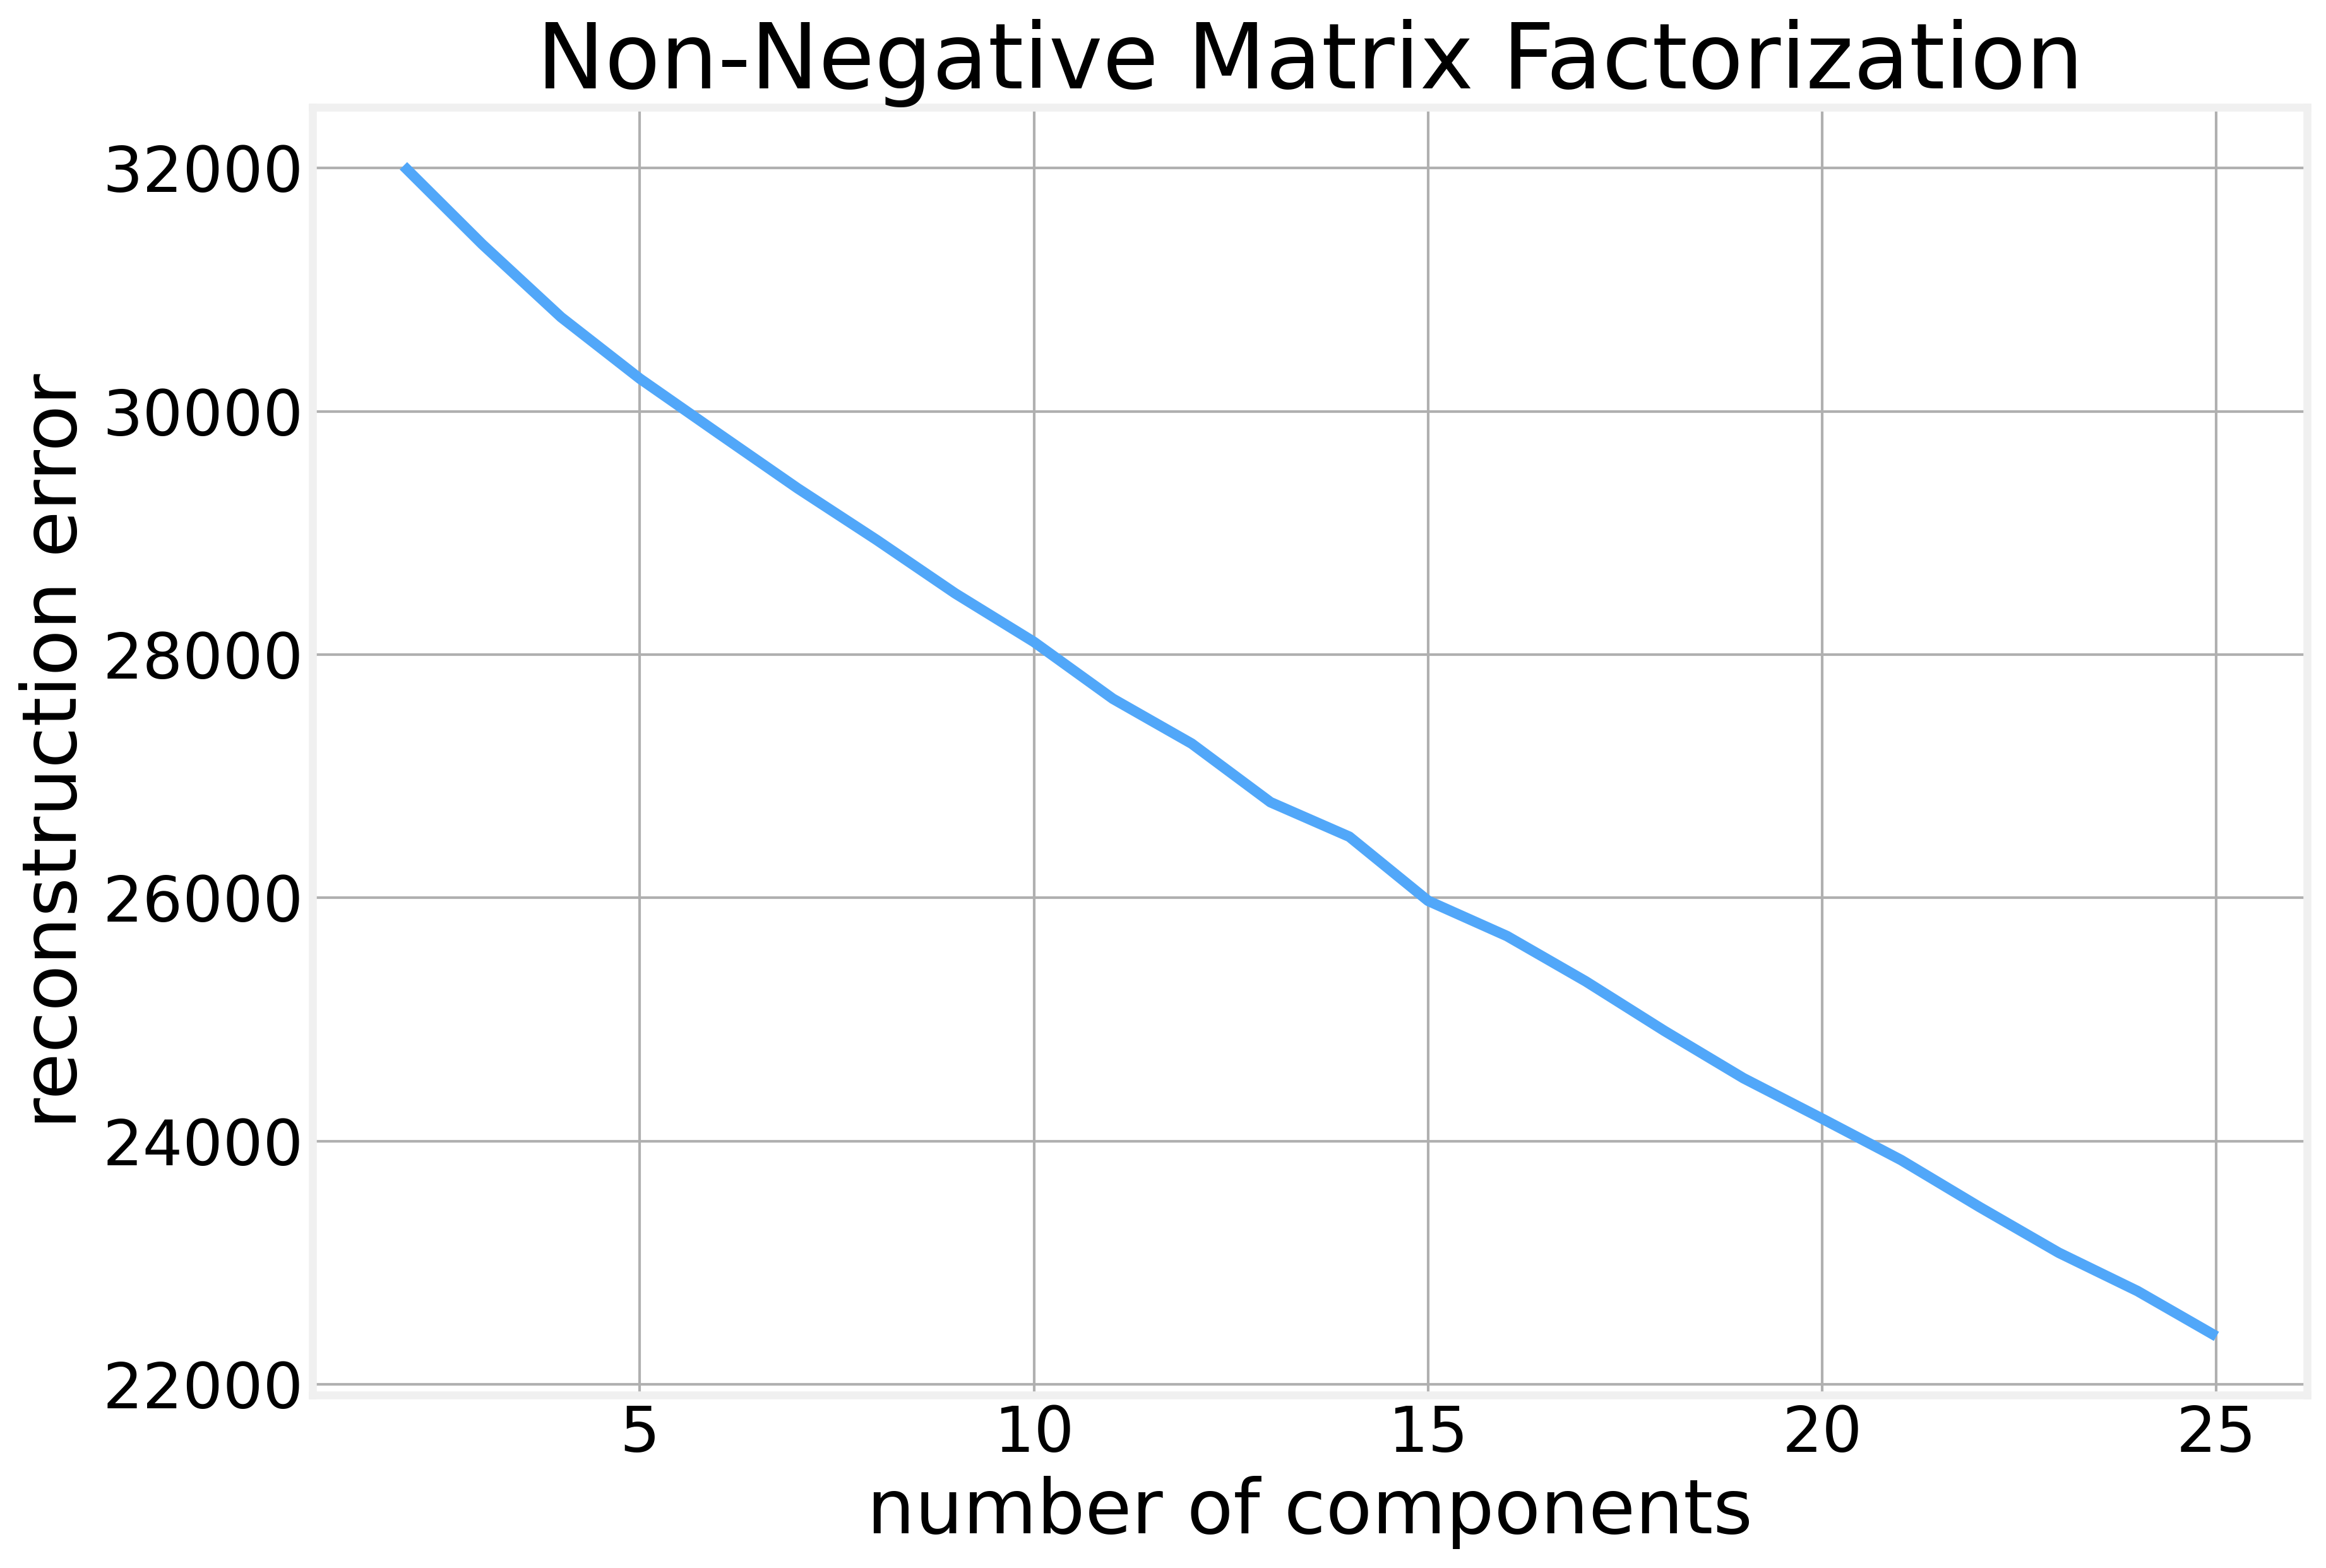

In [41]:
plt.plot(range(2, 25+1), error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('Non-Negative Matrix Factorization')

For the remainder of this section, lets fix the number of so that we can use these results to illustrate the power of NMF.

In [42]:
W, H, err = NMF(TDM, 10)

When we apply NMF to a Term-Document matrix, as defined above, the resulting factors prove useful for topic detection. In particular, the W matrix provides us with the definition of each topic as a weighted distribution over all the words in the corpus:

Let's look at a couple of examples:

In [43]:
topic_words = top_words(W[:,1], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

#macbook 19.891850036387524
#startup 19.812025876405333
@youtube 19.812025876405333
#hipster 19.812025876405333
#macbookpro 19.338601350526222
via 18.833766194169485
mini 13.512983049216068
ipad 13.126395941238178
#ipadmini 12.900359665908372
startup 12.535197684063256


In [44]:
topic_words = top_words(W[:,9], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

users 27.83105851617811
#cybermonday 14.19705443016489
6.6 13.915529258089055
#business 13.915529258089055
online 13.915529258089055
21.6 13.915529258089055
3x 13.915529258089055
@android 13.915529258089055
ibm 13.915529258089055
#sales 13.915529258089055


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>